In [2]:
'''
notebook for playing around with exporting files and georefrencing them in python

eventualy this will be tied together with alot of the scripts from sahi fiftyone into a smooth workflow

'''


# first check the wd
# this should be AIggregation folder

import os

print("cwd is", os.getcwd())

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("cwd changed to", os.getcwd())



cwd is /home/tmueller/github/AIggregation/notebooks
cwd changed to /home/tmueller/github/AIggregation


In [1]:
# export a test image with its label boxes
# mostly a test cell


import fiftyone as fo

# Import annotated test image into fiftyone dataset type
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/test_image/test.yaml"
)


# then export it again
export_dir = "datasets/export_test"
label_field = "ground_truth"  


dataset.export(
        export_dir=export_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=label_field
    )




 100% |█████████████████████| 1/1 [110.6ms elapsed, 0s remaining, 9.3 samples/s] 
Directory 'datasets/export_test' already exists; export will be merged with existing files
 100% |█████████████████████| 1/1 [33.1ms elapsed, 0s remaining, 30.2 samples/s] 


In [ ]:
# maybe easiest is just reading in the labels file (.csv) from the export and editing it into coordinates

# the name of the file containing the export labels would match the import file names - so ortho something

# multiply csv by image dimensions to get pixel coordinates
# use csv of pixel coordinate points to create a raster 
# use the affine transformation calculated by georefrencng the ortho image to do an identical transformation on the labels raster
# or just give it new meta data 






/home/tmueller/.local/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


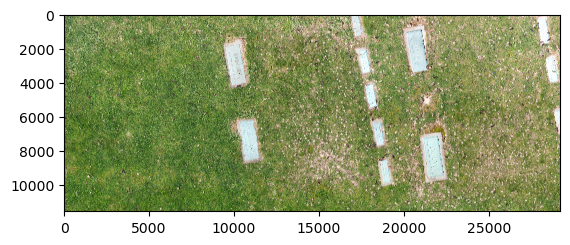

image pixel dimensions are:
(11552, 29184)
 
affine transformation:
| 0.00, 0.00, 379252.08|
| 0.00,-0.00, 4699477.40|
| 0.00, 0.00, 1.00|


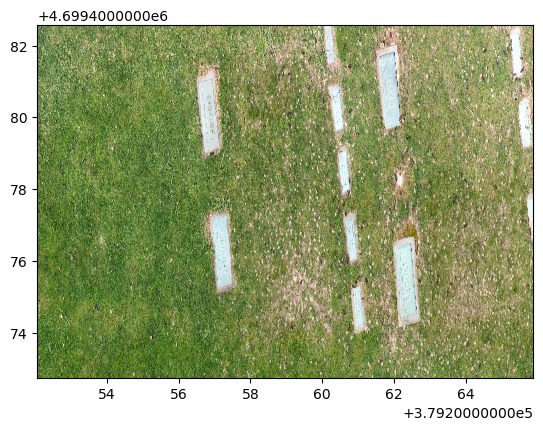

<AxesSubplot:>

In [8]:
# test out rasterio 
# and how to georef image via coordinates


#import required libraries
import rasterio
from rasterio.plot import show





# open ungeoreferenced raster
unRefRaster = rasterio.open('datasets/drone_ortho/ortho_clip_23april.png')
unRefRaster


# view raster
show(unRefRaster)


# show raster shape 
# this is needed to adjust detection points to pixel coordinates
print("image pixel dimensions are:")
print(unRefRaster.read(1).shape)



# now insert ground control points matching pixels to gps coordinates
# the best way is to open the uncropped orthomosaic in qgis. This is georeferenced based on the drones GPS
# find GCP coord and matching pixel coordinates


# this currently georeferences back to the orthophoto and the drones GPS

# NE corner of Holford plaque
gcp1 = rasterio.control.GroundControlPoint(col = 10304, row=1761, x=379256.53700, y=4699478.52032)
gcp1

# NE corner of Brooks plaque
gcp2 = rasterio.control.GroundControlPoint(col = 21997, row=7147, x=379262.19952, y=4699478.42842)
gcp2

# NE corner of Mabee plaque
gcp3 = rasterio.control.GroundControlPoint(col = 21015, row=916, x=379260.699480, y=4699480.76311)
gcp3

# NE corner of margorie mabee plaque
gcp4 = rasterio.control.GroundControlPoint(col = 28347,row=275, x=379263.53480, y=4699482.32240)
gcp4

# Stalk of pine cone SW of image
gcp5 = rasterio.control.GroundControlPoint(col = 3379, row=9200, x=379255.0672, y=4699474.2969)
gcp5



# list of selected gcps
gcp = [gcp1, gcp2, gcp3, gcp4, gcp5]
gcp

# get affine transformation
transformation = rasterio.transform.from_gcps(gcp)
print(" ")
print("affine transformation:")
print(transformation)



#define output raster path
outputPath = 'datasets/geo_test/georefRaster.tif'


#create raster and write bands
# by using the transformation and crs 
with rasterio.open(
    outputPath, # specify output raster file path
    'w', # 'w' to specify writing mode
    driver='GTiff', #name of deisred format driver
    height=unRefRaster.read(1).shape[0], #height, in this case taken from unreferenced raster
    width=unRefRaster.read(1).shape[1], #width, in this case taken from unreferenced raster
    count=3, # how many dataset bands (3 for standard color)
    dtype=unRefRaster.read(1).dtype, #data type of dataset
    crs=rasterio.crs.CRS.from_epsg(32618), #CRS.  (WGS84 18N)
    transform=transformation, # specify affine transformation to be used
) as dst: # write out bands
    dst.write(unRefRaster.read(1), 1)
    dst.write(unRefRaster.read(2), 2)
    dst.write(unRefRaster.read(3), 3)

#show georeferenced raster 
geoRaster = rasterio.open(outputPath)
show(geoRaster)





In [27]:
#The below gets the pixel coordinate centroids of each detection and saves it as a CSV file 



from PIL import Image
Image.MAX_IMAGE_PIXELS = 349501440


img = Image.open("datasets/drone_ortho/ortho_clip_23april.png")

# get and store image dimensions
print(img.size)

imgwidth = img.width
imgheight = img.height


import pandas as pd

labels_txt = "datasets/export_predictions/large_slices_large_overlap/ortho_clip_23april.txt"

labels = pd.read_csv(labels_txt, sep=' ', skiprows=2, names=['class', 'x', 'y', 'w', 'h', 'conf'])

# we need to rescale coordinates from 0-1 to real image height and width
labels[['x', 'w']] = labels[['x', 'w']] * imgwidth
labels[['y', 'h']] = labels[['y', 'h']] * imgheight

# i think yolo x1 and y1 are centroids so no need to worry about w and h as belo# now edit and read in a raster of detectionsw
#labels.x1 = labels.x1+(labels.w*0.5)
#labels.y1 = labels.x1-(labels.h*0.5)


centers = labels[["x","y"]]
centers.y = centers.y*-1 #because qgis maps things flipped
centers["z"] = 0

centers.to_csv("datasets/test_centroids_qgis.csv", index=False)





(29184, 11552)


/tmp/ipykernel_510865/3675379428.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centers.y = centers.y*-1 #because qgis maps things flipped
/tmp/ipykernel_510865/3675379428.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centers["z"] = 0


In [30]:
# test applying affine transformation to csv of points
import numpy as np


arr = np.genfromtxt("datasets/test_centroids_qgis.csv",
                 delimiter=",", dtype=str)
display(arr)




print(transformation)

test = np.matmul(arr, transformation)



array([['x', 'y', 'z'],
       ['25299.551231999998', '-10754.241984', '0'],
       ['12082.176', '-8739.6656', '0'],
       ...,
       ['20683.372032', '-256.33888', '0'],
       ['23382.892032', '-8766.604863999999', '0'],
       ['12214.788096', '-2467.668928', '0']], dtype='<U19')

| 0.00, 0.00, 379252.08|
| 0.00,-0.00, 4699477.40|
| 0.00, 0.00, 1.00|


UFuncTypeError: ufunc 'matmul' did not contain a loop with signature matching types (dtype('<U19'), dtype('float64')) -> None